Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from lcapy import *
from lcapy.discretetime import *

# Set up some simulation parameters

stim_duration = 5                 
fs = 500000        
Delta_t = 1 / (fs)
print(Delta_t)
pad_factor = 4
N = stim_duration*fs
num_chosen_freqs = 25
f = np.fft.fftfreq(pad_factor*N, Delta_t)
t = np.arange(0,N) / fs
t2 = np.arange(0,pad_factor*N) / fs


plt.rcParams["figure.figsize"] = (20,10)


# Component Values

R1 = [0,0,0]
R2 = [0,0,0]
R3 = [0,0,0]
Q1 = [0,0,0]
Q2 = [0,0,0]
B1 = [0,0,0]
B2 = [0,0,0]

#Ag_AgCl_SP Average:
R1[0] = 302;
R2[0] = 1270;
R3[0] = 1720;
Q1[0] = 3.9e-6;
B1[0] = 0.678;
Q2[0] = 2.48e-3;
B2[0] = 0.589;

#Ag_AgCl_NSP avg

R1[1] = 183;
R2[1] = 5.46e6;
R3[1] = 12e6;
Q1[1] = 61.2e-9;
B1[1] = 0.895;
Q2[1] = 15.1e-6;
B2[1] = 0.591;

#Ag_AgCl_NSP

R1[2] = 331;
R2[2] = 53.7e3;
R3[2] = 722e3;
Q1[2] = 18.2e-6;
B1[2] = 0.606;
Q2[2] = 5.63e-6;
B2[2] = 0.669;

2e-06


Create a series of input signals - an impulse, a train of five impulses, a sum of known cosines, and a pseudorandom white noise signal.

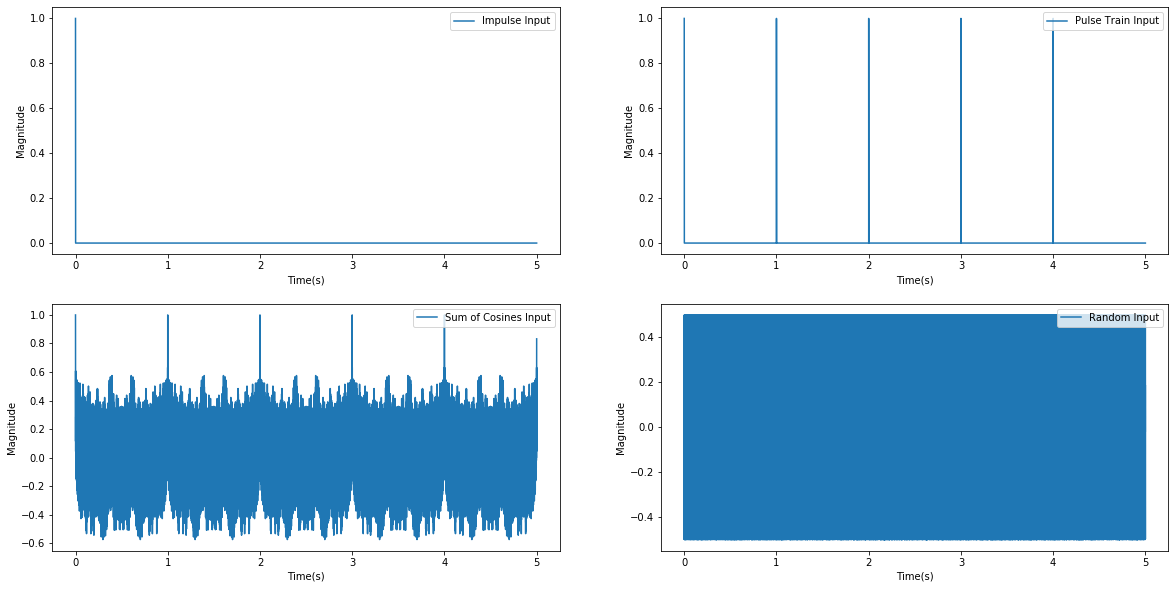

In [2]:
# Create impulse input
stim_impulse = np.zeros(N)
stim_impulse[0] = 1

# Create Pulse Train input
stim_train = np.zeros(N)
for ii in range(0, stim_duration):
    one_hz = ((ii)*((N) // stim_duration))
    stim_train[int(one_hz)] = 1
stim_train = stim_train


# Create a sum of cosines of known frequencies

# Pick integer frequencies only to increase approximation 
#      accuracy/remove need for padding + windowing later (maybe)
stim_sum = np.zeros(N)
chosen_freqs = np.logspace(0,np.log10(fs/2),num_chosen_freqs)
chosen_freqs = np.unique(np.rint(chosen_freqs)) # Round and remove duplicate 1Hz entries
num_final_freqs = len(chosen_freqs)

for i in range(num_final_freqs):
    stim_sum = stim_sum + (1/num_final_freqs)*np.cos(2*np.pi*chosen_freqs[i]*t)
#Shift and scale this to 1 (don't do for now, leave commented out until the fft is sorted).
#stim_sum = stim_sum - np.amin(stim_sum)
#stim_sum = stim_sum / np.amax(stim_sum)

#Create pseudorandom signal (model white noise)
stim_rand = np.random.rand(N) - 0.5;


#Display discrete-time stimulation signals

plt.figure(1)

ax = plt.subplot(221)
plt.plot(t,stim_impulse, label='Impulse Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   

ax = plt.subplot(222)
plt.plot(t,stim_train, label='Pulse Train Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   

ax = plt.subplot(223)
plt.plot(t,stim_sum, label='Sum of Cosines Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   

ax = plt.subplot(224)
plt.plot(t,stim_rand, label='Random Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   

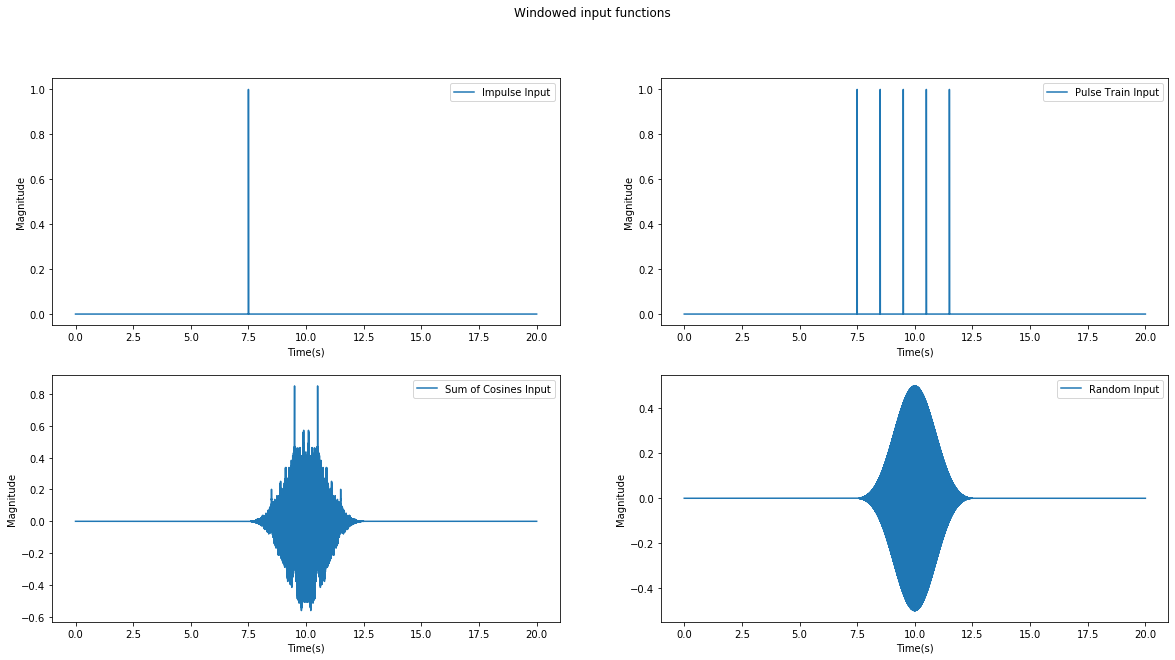

In [3]:
# window = np.hamming(N)
window = np.blackman(N)
# window = np.ones(N)

#don't bother windowing stim_impulse, will just go to 0
stim_impulse = stim_impulse
stim_train = stim_train
stim_sum = stim_sum * window
stim_rand = stim_rand * window

#Pad
stim_impulse = np.pad(stim_impulse,int((pad_factor-1)/2*N))
# stim_impulse = np.append(stim_impulse, np.zeros(N))

stim_train = np.pad(stim_train,int((pad_factor-1)/2*N))
stim_sum = np.pad(stim_sum,int((pad_factor-1)/2*N))
stim_rand = np.pad(stim_rand,int((pad_factor-1)/2*N))



#VISUALISE WINDOWED PADDED INPUTS
fig = plt.figure(9)
fig.suptitle("Windowed input functions") 

ax = plt.subplot(221)
plt.plot(t2,stim_impulse, label='Impulse Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right");   

ax = plt.subplot(222)
plt.plot(t2,stim_train, label='Pulse Train Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right");   

ax = plt.subplot(223)
plt.plot(t2,stim_sum, label='Sum of Cosines Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right");   

ax = plt.subplot(224)
plt.plot(t2,stim_rand, label='Random Input')
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right");

Perform DFT on above signals

Fourier Coefficients 



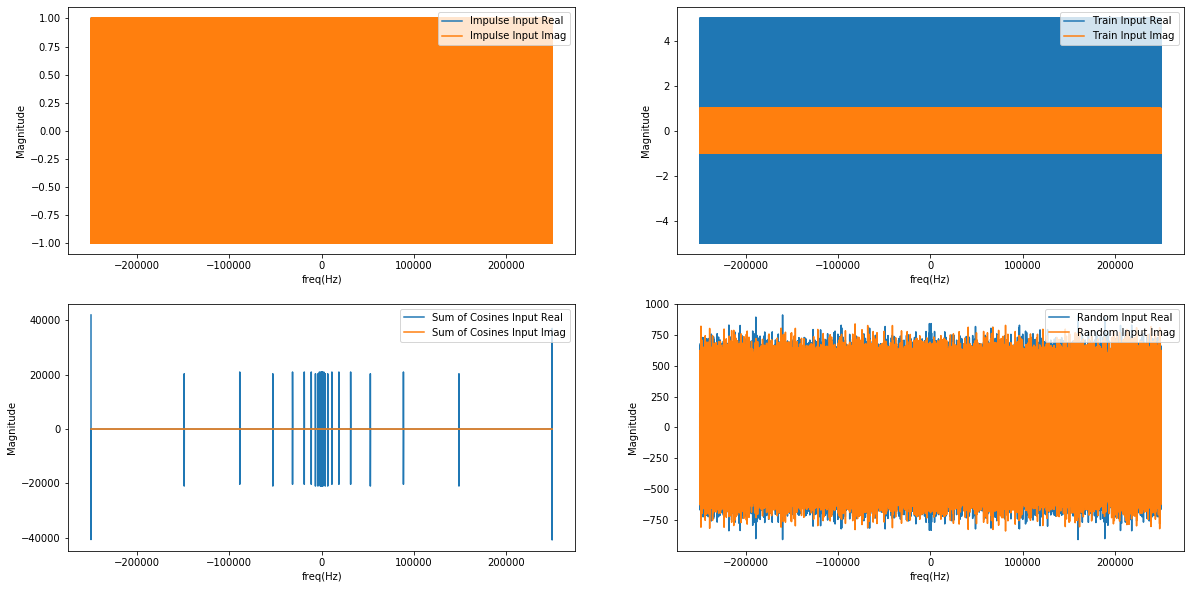

In [4]:
almost_zero = 1e-8

f_stim_impulse = np.fft.fft(stim_impulse)# * 2/N
f_stim_impulse[np.abs(f_stim_impulse) < almost_zero] = 0
f_stim_train = np.fft.fft(stim_train)# * 2/N
f_stim_train[np.abs(f_stim_train) < almost_zero] = 0
f_stim_sum = np.fft.fft(stim_sum)# * 2/N
f_stim_sum[np.abs(f_stim_sum) < almost_zero] = 0
f_stim_rand = np.fft.fft(stim_rand)# * 2/N
f_stim_rand[np.abs(f_stim_rand) < almost_zero] = 0

print("Fourier Coefficients \n")

plt.figure(2)

ax = plt.subplot(221)
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.real(f_stim_impulse)), label='Impulse Input Real')
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.imag(f_stim_impulse)), label='Impulse Input Imag')
ax.set_xlabel("freq(Hz)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   


ax = plt.subplot(222)
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.real(f_stim_train)), label='Train Input Real')
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.imag(f_stim_train)), label='Train Input Imag')
ax.set_xlabel("freq(Hz)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   


ax = plt.subplot(223)
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.real(f_stim_sum)), label='Sum of Cosines Input Real')
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.imag(f_stim_sum)), label='Sum of Cosines Input Imag')
ax.set_xlabel("freq(Hz)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   


ax = plt.subplot(224)
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.real(f_stim_rand)), label='Random Input Real')
plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.imag(f_stim_rand)), label='Random Input Imag')
ax.set_xlabel("freq(Hz)")
ax.set_ylabel("Magnitude")
ax.legend(loc="upper right")   





In [5]:
# #Inverse DFT to reconstruct the initial impulse - use to check you haven't messed up the fft
# almost_zero = 1e-6

# stim_impulse = np.fft.ifft(f_stim_impulse)# / (2/N)
# #stim_impulse[np.abs(stim_impulse) < almost_zero] = 0
# stim_train = np.fft.ifft(f_stim_train)#  / (2/N)
# #stim_train[np.abs(stim_train) < almost_zero] = 0
# stim_sum = np.fft.ifft(f_stim_sum)# / (2/N)
# #stim_sum[np.abs(stim_sum) < almost_zero] = 0
# stim_rand = np.fft.ifft(f_stim_rand) # / (2/N)
# #stim_rand[np.abs(stim_rand) < almost_zero] = 0

# print("Fourier Coefficients \n")


# fig = plt.figure(10)
# fig.suptitle("Windowed input functions") 

# ax = plt.subplot(221)
# plt.plot(t2,stim_impulse.real, label='Impulse Input')
# ax.set_xlabel("Time(s)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right");   

# ax = plt.subplot(222)
# plt.plot(t2,stim_train.real, label='Pulse Train Input')
# ax.set_xlabel("Time(s)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right");   

# ax = plt.subplot(223)
# plt.plot(t2,stim_sum.real, label='Sum of Cosines Input')
# ax.set_xlabel("Time(s)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right");   

# ax = plt.subplot(224)
# plt.plot(t2,stim_rand.real, label='Random Input')
# ax.set_xlabel("Time(s)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right");   



In [6]:
#Create up to three sets of electrode impedance data from components
#Note: make CPEs into capacitors by setting B1, B2, B3 = 1
B1 = [1,1,1]
B2 = [1,1,1]

z = np.zeros((3,len(f)), dtype=complex)
zt = np.zeros((3,len(f)), dtype=complex)
num_electrodes = 2
#Use z equation in f domain to get complex impedance at all freqs in f
for nn in range(num_electrodes):
    for kk in range(0,len(f)):
        z[nn,kk] = R1[nn] + 1/(Q1[nn]*((1j*2*np.pi*f[kk])**B1[nn] + 1/(R2[nn]*Q1[nn]))) + 1/(Q2[nn]*((1j*2*np.pi*f[kk])**B2[nn] + 1/(Q2[nn]*R3[nn])))
  

# Visualise freq domain impedance to check that they're correct - slow
# plt.figure(6)

# ax = plt.subplot(311)
# plt.loglog(abs(f),abs(z[0,:]), label='Example Electrode 1')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Impedance")
# ax.legend(loc="upper right");   

# ax = plt.subplot(312)
# plt.loglog(abs(f),abs(z[1,:]), label='Example Electrode 2')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Impedance")
# ax.legend(loc="upper right");   

# ax = plt.subplot(313)
# plt.loglog(abs(f),abs(z[2,:]), label='Example Electrode 3')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Impedance")
# ax.legend(loc="upper right");      

       



Set up electrode impedances

In [7]:
#Try to jam the two together for electrode 1...

#note: z data is based on f vector from fftfreq, so doesn't need shifted
response1_f= np.zeros((4,len(f)), dtype=complex)
response1_f[0,:] = f_stim_impulse * z[1,:]
response1_f[1,:] = f_stim_train * z[1,:]
response1_f[2,:] = f_stim_sum * z[1,:]
response1_f[3,:] = f_stim_rand * z[1,:]


#Visualise fourier response - not that useful as I don't know what I'm looking at - very slow.
# # if using loglog) these plots are huge and jagged so they break the agg backend, tell it to compute lines in smaller chunks
# mpl.rcParams['agg.path.chunksize'] = 10000

# plt.figure(7)
# ax = plt.subplot(221)
# # plt.loglog(abs(f), np.real(response1_f[0]), label='Real Impulse response in f domain')
# # plt.loglog(abs(f), abs(np.imag(response1_f[0])), label='Imag Impulse response in f domain')
# plt.semilogy(f, np.fft.fftshift(np.real(response1_f[0])), label='Real Impulse response in f domain')
# plt.semilogy(f, np.fft.fftshift(abs(np.imag(response1_f[0]))), label='Imag Impulse response in f domain')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right")

# ax = plt.subplot(222)
# # plt.loglog(abs(f), abs(response1_f[1]), label='Real Train response in f domain')
# # plt.loglog(abs(f), abs(np.imag(response1_f[1])), label='Imag Train response in f domain')
# plt.semilogy(f, np.fft.fftshift(np.real(response1_f[1])), label='Real Impulse response in f domain')
# plt.semilogy(f, np.fft.fftshift(abs(np.imag(response1_f[1]))), label='Imag Impulse response in f domain')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right")

# ax = plt.subplot(223)
# # plt.loglog(abs(f), abs(response1_f[2]), label='Real S-O-C response in f domain')
# # plt.loglog(abs(f), abs(np.imag(response1_f[2])), label='Imag S-O-C response in f domain')
# plt.semilogy(f, np.fft.fftshift(np.real(response1_f[2])), label='Real Impulse response in f domain')
# plt.semilogy(f, np.fft.fftshift(abs(np.imag(response1_f[2]))), label='Imag Impulse response in f domain')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right")

# ax = plt.subplot(224)
# # plt.loglog(abs(f), abs(response1_f[3]), label='Real Random response in f domain')
# # plt.loglog(abs(f), abs(np.imag(response1_f[3])), label='Imag Random response in f domain')
# plt.semilogy(f, np.fft.fftshift(np.real(response1_f[3])), label='Real Impulse response in f domain')
# plt.semilogy(f, np.fft.fftshift(abs(np.imag(response1_f[3]))), label='Imag Impulse response in f domain')
# ax.set_xlabel("freq(Hz)")
# ax.set_ylabel("Magnitude")
# ax.legend(loc="upper right")


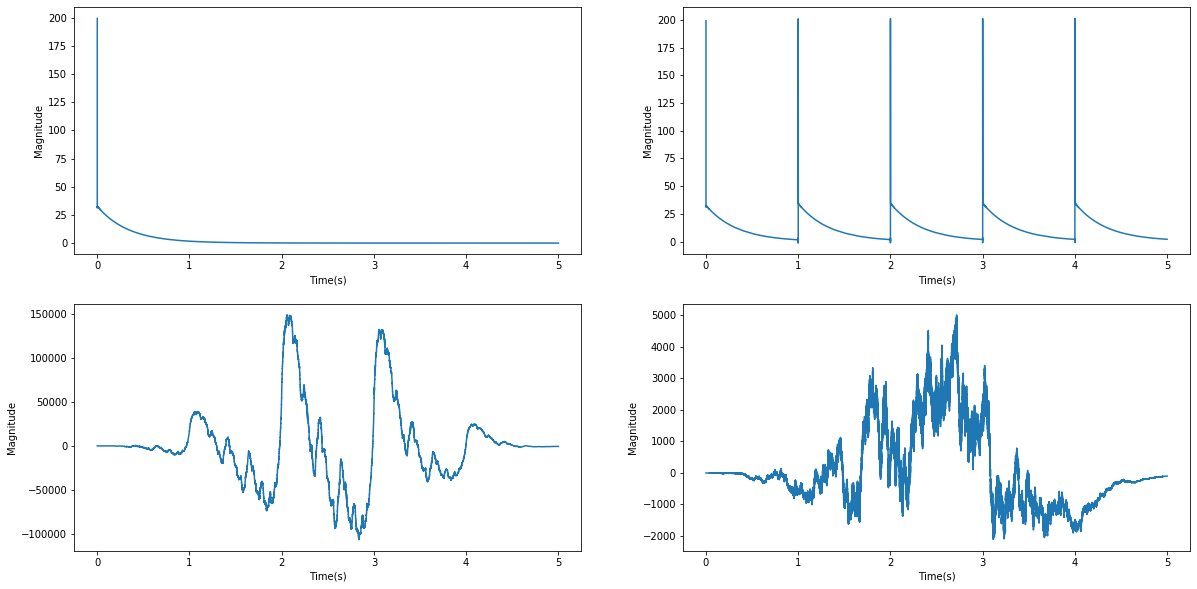

In [8]:
#Bring back into time domain
response1_t= np.zeros((4,pad_factor*N), dtype=complex)
response1_t[0,:] = np.fft.ifft(response1_f[0])# * iwindow_pad
response1_t[1,:] = np.fft.ifft(response1_f[1])# * iwindow_pad
response1_t[2,:] = np.fft.ifft(response1_f[2])# * iwindow_pad
response1_t[3,:] = np.fft.ifft(response1_f[3])# * iwindow_pad

#remove dc
response1_t[0,:] = response1_t[0,:] - response1_t[0,N//4]
response1_t[1,:] = response1_t[1,:] - response1_t[1,N//4]
response1_t[2,:] = response1_t[2,:] - response1_t[2,N//4]
response1_t[3,:] = response1_t[3,:] - response1_t[3,N//4]

#remove 0 pad
response1 = np.zeros((4,N), dtype=complex)
response1[0,:] = response1_t[0,int((pad_factor-1)/2*N):int(pad_factor*N - (pad_factor-1)/2*N)]
response1[1,:] = response1_t[1,int((pad_factor-1)/2*N):int(pad_factor*N - (pad_factor-1)/2*N)]
response1[2,:] = response1_t[2,int((pad_factor-1)/2*N):int(pad_factor*N - (pad_factor-1)/2*N)]
response1[3,:] = response1_t[3,int((pad_factor-1)/2*N):int(pad_factor*N - (pad_factor-1)/2*N)]

plt.figure(8)

ax = plt.subplot(221)
plt.plot(t, np.abs(response1[0]))
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")

ax = plt.subplot(222)
plt.plot(t, np.real(response1[1]))
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")

ax = plt.subplot(223)
plt.plot(t, np.real(response1[2]))
ax.set_xlabel("Time(s)")
ax.set_ylabel("Magnitude")

ax = plt.subplot(224)
plt.plot(t, np.real(response1[3]))
ax.set_xlabel("Time(s)");
ax.set_ylabel("Magnitude");


Create Analytical Impulse response (using lcapy)

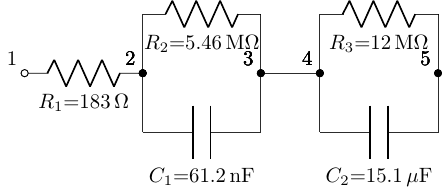

          25278625000
183⋅ⅉ⋅ω + ───────────
              1547   
─────────────────────
           125000    
     ⅉ⋅ω + ──────    
           41769     

In [9]:
cct = Circuit("""
R1 1 2; right
R2 2 3; right, offset=0.5
C1 2 3; right, offset=-0.5
W 3 4; right=0.5
R3 4 5; right, offset=0.5
C2 4 5; right, offset=-0.5
""")

defs = {'R1':R1[1], 'R2':R2[1], 'C1':Q1[1], 'R3':R3[1], 'C2':Q2[1]}

cct = cct.subs(defs)
cct.draw()

Z=cct.impedance(1, 4)
Z(omega)

In [10]:
Zd = Z(s).bilinear_transform().simplify()
Zd = Zd.subs({dt: Delta_t})
Zd

   ⎛2467037⋅z   2062579⎞
27⋅⎜───────── - ───────⎟
   ⎝    8          8   ⎠
────────────────────────
   334153⋅z   334151    
   ──────── - ──────    
      8         8       

In [11]:
z_n = Zd(n)
z_n

                      n                     
              ⎛334151⎞                      
3648939840000⋅⎜──────⎟ ⋅u(n)                
              ⎝334153⎠         55689633⋅δ[n]
──────────────────────────── + ─────────────
        111657559103               334151   

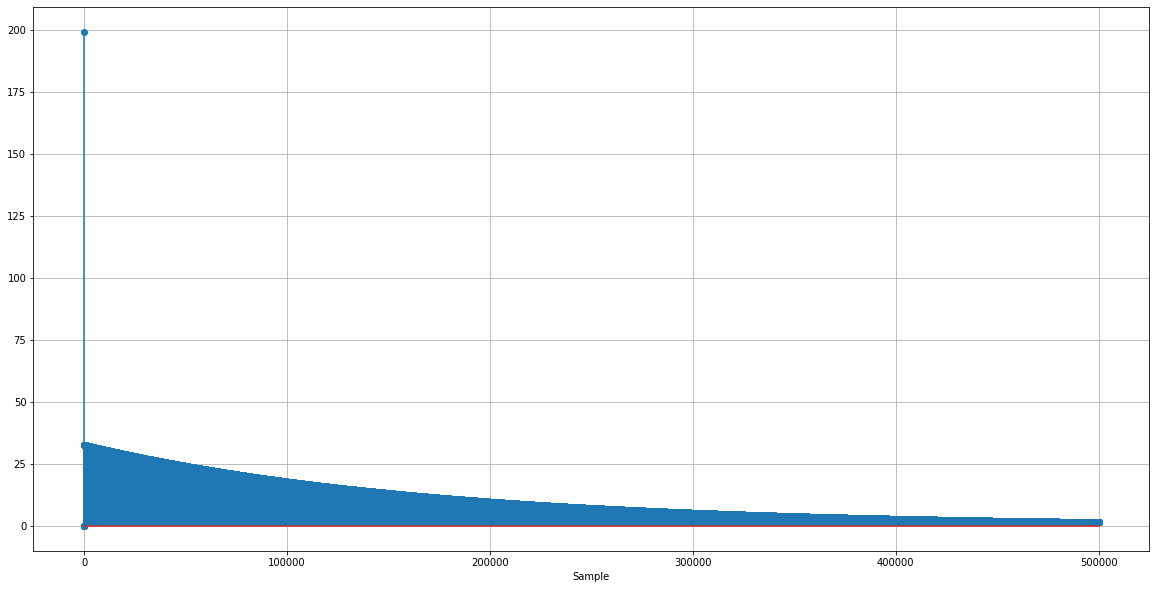

In [12]:
z_n.plot(n=(-5,5e5), use_line_collection='true')

In [17]:
#transfer into this scripts variables - probably an easier way but I do not know it
z_analytical_step = np.zeros(N)
z_analytical_impulse = np.zeros(N)

delta_n = np.zeros(N)
u_n = np.ones(N)
delta_n[0] = 1


for NN in range(0,N):
    z_analytical_step[NN] = 3648939840000*(334151/334153)**NN*u_n[NN]/111657559103

    z_analytical_impulse[NN] =  55689633*delta_n[NN]/334151


Z_analytical_double = z_analytical_step + z_analytical_impulse;




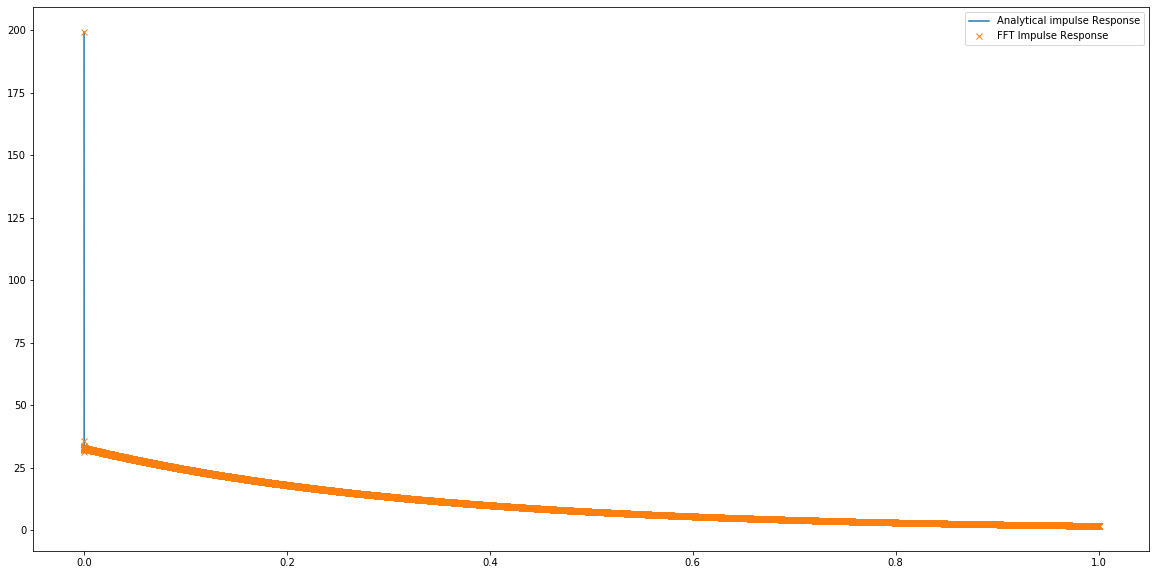

In [18]:
plt.figure(11)

ax = plt.subplot(111)
plt.plot(t[0:N//stim_duration],Z_analytical_double[0:N//stim_duration], label='Analytical impulse Response')
plt.plot(t[0:N//stim_duration],np.abs(response1[0,0:N//stim_duration]), 'x', label='FFT Impulse Response')
ax.legend(loc='upper right')






In [15]:
print(z_n)

3648939840000*(334151/334153)**n*Heaviside(n)/111657559103 + 55689633*UnitImpulse(n)/334151
